In [1]:
#from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation  
from keras.layers import AveragePooling2D, Input, Flatten               
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler      
from keras.callbacks import ReduceLROnPlateau                           
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar100   #,cifar100
import numpy as np
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#********************************************************************Training Parameters*********************************************************#


'''
Paper - 
We ran all our CIFAR experiments with 3 seeds and trained for 
200 epochs on a ResNet-18 [11] with batches of 128 images and decay 
the learning rate by a factor of 5 at the 60th, 120th, and 160th epochs.
'''

batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 100 #no. of classes for the data set, 100 in case of cifar100

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 18

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)



In [3]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
# subtract pixel mean provided as arg in the training params

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
# one hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [6]:
len(y_test[0]) #verifying 100 classes

100

In [7]:
def plot_losses(train_loss, epoch, seed):
    """Plot the training and validn losses
    Args:
    train_loss (list): list of train losses for seed value
    epochs (int) - the no. of epochs
    """
    
    epoch_list = list(range(1,epoch+1))
    plt.plot(epoch_list, train_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss for seed ",seed)
    plt.show()

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training. To be fed as an arg to the LearningRateScheduler function.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [ ]:
seed_list = [0, 19]
vald_acc_list = []
epochs = 200
train_loss_data = {} #to store the training losses v/s epochs for different seeds

for seed in seed_list:
    
    np.random.seed(seed)
  
    print("\n\n*****************\n\nSeed Value:", seed)

  #********************************Build the Model**************************************#

    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth, num_classes=num_classes)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth, num_classes=num_classes)

    model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=lr_schedule(0)),
                metrics=['accuracy'])
    #model.summary()
    print(model_type)

    # Prepare model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = 'cifar100_adam_%s_model.{epoch:03d}.h5' % model_type
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)

  # Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='val_acc',
                              verbose=1,
                              save_best_only=True)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                cooldown=0,
                                patience=5,
                                min_lr=0.5e-6)

    callbacks = [checkpoint, lr_reducer, lr_scheduler]

    #*************************************************************************************#
    # Run training, with or without data augmentation.
    if not data_augmentation:
        print('Not using data augmentation.')
        hist = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                shuffle=True,
                callbacks=callbacks)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
          # set input mean to 0 over the dataset
          featurewise_center=False,
          # set each sample mean to 0
          samplewise_center=False,
          # divide inputs by std of dataset
          featurewise_std_normalization=False,
          # divide each input by its std
          samplewise_std_normalization=False,
          # apply ZCA whitening
          zca_whitening=False,
          # epsilon for ZCA whitening
          zca_epsilon=1e-06,
          # randomly rotate images in the range (deg 0 to 180)
          rotation_range=0,
          # randomly shift images horizontally
          width_shift_range=0.1,
          # randomly shift images vertically
          height_shift_range=0.1,
          # set range for random shear
          shear_range=0.,
          # set range for random zoom
          zoom_range=0.,
          # set range for random channel shifts
          channel_shift_range=0.,
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          # value used for fill_mode = "constant"
          cval=0.,
          # randomly flip images
          horizontal_flip=True,
          # randomly flip images
          vertical_flip=False,
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

        # Compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                      validation_data=(x_test, y_test),
                      epochs=epochs, verbose=1, workers=4,
                      callbacks=callbacks)

    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

    # Store the best validation accuracy
    vald_acc_list.append(max(hist.history['val_accuracy']))

    train_loss_data[seed] = hist.history['loss']



*****************

Seed Value: 0
Learning rate:  0.001
ResNet110v1
Using real-time data augmentation.
Epoch 1/200
Learning rate:  0.001
391/391 [==============================] - 120s 307ms/step - loss: 5.3034 - accuracy: 0.0590 - val_loss: 4.7449 - val_accuracy: 0.0894
Epoch 2/200
Learning rate:  0.001


/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


391/391 [==============================] - 84s 215ms/step - loss: 4.2775 - accuracy: 0.1489 - val_loss: 4.3553 - val_accuracy: 0.1497
Epoch 3/200
Learning rate:  0.001
391/391 [==============================] - 84s 215ms/step - loss: 3.7973 - accuracy: 0.2208 - val_loss: 3.9034 - val_accuracy: 0.2022
Epoch 4/200
Learning rate:  0.001
391/391 [==============================] - 84s 214ms/step - loss: 3.4415 - accuracy: 0.2786 - val_loss: 3.9214 - val_accuracy: 0.2199
Epoch 5/200
Learning rate:  0.001
391/391 [==============================] - 84s 214ms/step - loss: 3.1588 - accuracy: 0.3276 - val_loss: 3.2211 - val_accuracy: 0.3198
Epoch 6/200
Learning rate:  0.001
391/391 [==============================] - 84s 214ms/step - loss: 2.9341 - accuracy: 0.3702 - val_loss: 3.3335 - val_accuracy: 0.2979
Epoch 7/200
Learning rate:  0.001
391/391 [==============================] - 85s 218ms/step - loss: 2.7564 - accuracy: 0.4018 - val_loss: 3.6363 - val_accuracy: 0.2921
Epoch 8/200
Learning rate:

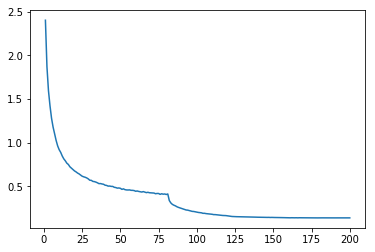

In [24]:
# plot the training losses for the last seed
plot_losses(hist, epochs)

In [18]:
vald_acc_list

[0.9259999990463257, 0.9290000200271606]

In [ ]:
np.mean(vald_acc_list)

In [19]:
train_loss_data

{0: [2.6559769387054444,
  1.9888095721435546,
  1.6877682561111451,
  1.4759823597335815,
  1.3117627983856202,
  1.1974617961883545,
  1.097841213684082,
  1.0307145183563233,
  0.9676643808746338,
  0.9105111316108704,
  0.8720414292144776,
  0.8401283836555481,
  0.8028762971496582,
  0.777941478214264,
  0.7466400580215454,
  0.7313996863746643,
  0.7016096379470825,
  0.6917153122901917,
  0.6687443489646911,
  0.6598059725379943,
  0.637718550491333,
  0.6308467712020874,
  0.6222683847808838,
  0.6043203674316406,
  0.6017908477020264,
  0.584237246723175,
  0.573122409696579,
  0.5695135766887665,
  0.5565287719535827,
  0.5543676832199097,
  0.5429521825408935,
  0.5381252869224549,
  0.5433513486862183,
  0.5248992875480651,
  0.5172210215950013,
  0.5129884754085541,
  0.5043712093544006,
  0.5028504744720459,
  0.5006939131736755,
  0.48858120212554934,
  0.4837458912467957,
  0.4785577852058411,
  0.47903715230941774,
  0.4686585667800903,
  0.4764939058113098,
  0.474190

In [20]:
import json

In [21]:
with open('./saved_data/train_losses_Cifar100.json', 'w') as fp:
    json.dump(train_loss_data, fp)